# Warm-Starting Trajectory Optimization 

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()
from IPython.display import HTML
import seaborn as sns

In [2]:
import mantrap
import mantrap_evaluation

env, goal, _ = mantrap_evaluation.scenarios.custom_passing(mantrap.environment.Trajectron)
solver = mantrap.solver.SGradSolver(env=env, goal=goal, is_logging=True)

z_warm_start = solver.solve(time_steps=10, warm_start_method=mantrap.constants.WARM_START_SOFT)
HTML(solver.visualize_scenes(tag=mantrap.constants.TAG_OPTIMIZATION))

In [3]:
import pandas
pandas.set_option('display.max_rows', 200)
solver.logger.log_store(csv_name=None, log_types=[mantrap.constants.LT_OBJECTIVE, 
                                                  mantrap.constants.LT_CONSTRAINT, 
                                                  mantrap.constants.LT_GRADIENT])

,0,1,2,3,4,5,6,7,8,9
warm_start/obj_goal_norm_0,2.477307e+01,2.981308e+01,2.826710e+01,2.657568e+01,2.564478e+01,2.547412e+01,2.542421e+01,25.424208,25.424208,25.424208
warm_start/obj_speed_limits_0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
warm_start/obj_hj_reachability_0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
warm_start/obj_overall_0,2.477307e+01,2.981308e+01,2.826710e+01,2.657568e+01,2.564478e+01,2.547412e+01,2.542421e+01,25.424208,25.424208,25.424208
optimization/obj_interaction_prob_0,-1.381551e+01,-1.381551e+01,-1.381551e+01,-1.381551e+01,-1.381551e+01,NaN,NaN,NaN,NaN,NaN
optimization/obj_speed_limits_0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN
optimization/obj_hj_reachability_0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN
optimization/obj_overall_0,-1.381551e+01,-1.381551e+01,-1.381551e+01,-1.381551e+01,-1.381551e+01,NaN,NaN,NaN,NaN,NaN
optimization/obj_interaction_prob_1,2.524542e+01,2.524542e+01,2.524542e+01,2.524542e+01,2.524542e+01,2.524542e+01,NaN,NaN,NaN,NaN
optimization/obj_speed_limits_1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN


### ... using hard optimization problem 

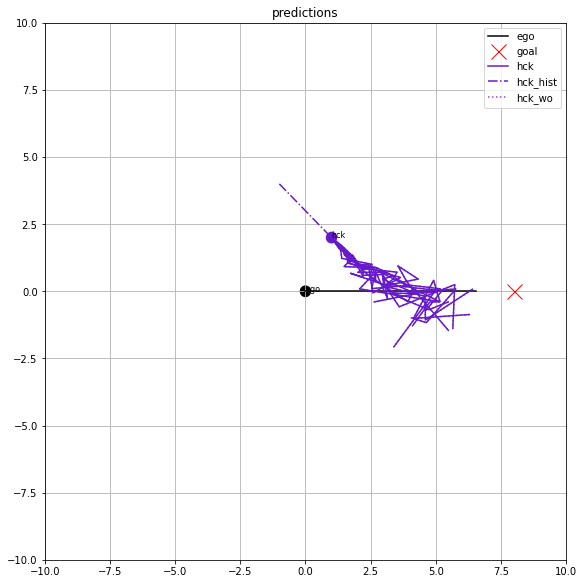

In [2]:
import mantrap
import mantrap_evaluation


env, goal, _ = mantrap_evaluation.scenarios.custom_passing(mantrap.environment.Trajectron)
solver = mantrap.solver.SGradSolver(env=env, goal=goal, is_logging=True, t_planning=10)

z_warm_start = solver.warm_start(method=mantrap.constants.WARM_START_HARD)
solver.visualize_step(tag=mantrap.constants.TAG_WARM_START, legend=True)
plt.show()

In [3]:
solver.logger.log_store(csv_name=None)

,0,1,2,3,4,5,6,7,8,9,10,11
warm_start/obj_goal_norm_0,16.414961,28.745148,23.310713,18.923874,16.833519,16.471645,16.304232,16.272942,16.262087,16.25886,16.258375,16.258375
warm_start/obj_speed_limits_0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
warm_start/obj_overall_0,16.414961,28.745148,23.310713,18.923874,16.833519,16.471645,16.304232,16.272942,16.262087,16.25886,16.258375,16.258375
warm_start/inf_goal_norm_0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN
warm_start/inf_speed_limits_0,25.184000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN
warm_start/inf_overall_0,25.184000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN


### ... using soft optimization problem 

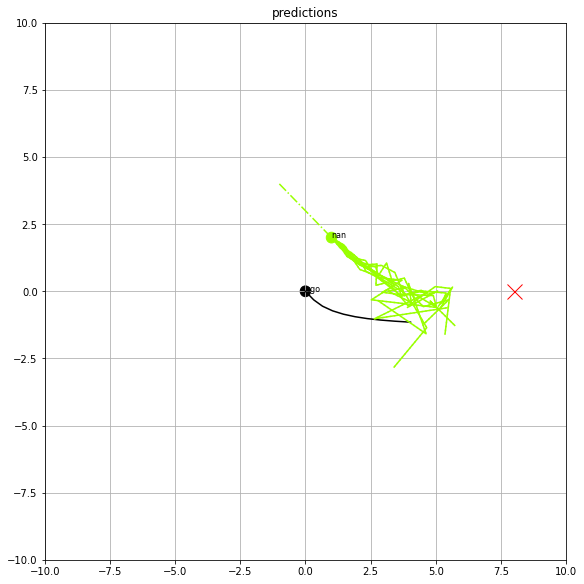

In [4]:
import mantrap
import mantrap_evaluation

env, goal, _ = mantrap_evaluation.scenarios.custom_passing(mantrap.environment.Trajectron)
solver = mantrap.solver.SGradSolver(env=env, goal=goal, is_logging=True, t_planning=10)

z_warm_start = solver.warm_start(method=mantrap.constants.WARM_START_SOFT)
solver.visualize_step(tag=mantrap.constants.TAG_WARM_START)
plt.show()

In [5]:
solver.logger.log_store(csv_name=None)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
warm_start/obj_goal_norm_0,16.414961,17.256315,17.272261,17.043663,16.819986,16.817482,16.818090,16.818102,16.818096,16.818092,...,21.080721,21.080729,21.080610,21.080736,21.450859,21.504433,21.426659,21.418917,21.418068,21.418068
warm_start/obj_speed_limits_0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
warm_start/obj_hj_reachability_0,39.567650,22.226183,22.049570,21.990761,21.909065,21.905842,21.903154,21.903112,21.903133,21.903143,...,21.903183,21.903187,21.903112,21.903193,21.904331,21.907524,21.903238,21.903112,21.903112,21.903112
warm_start/obj_overall_0,55.982613,39.482498,39.321831,39.034424,38.729050,38.723324,38.721245,38.721214,38.721230,38.721237,...,42.983906,42.983913,42.983723,42.983929,43.355190,43.411957,43.329895,43.322029,43.321178,43.321178
warm_start/inf_goal_norm_0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
warm_start/inf_speed_limits_0,25.184000,10.287155,10.157015,9.634796,9.183091,9.174715,9.171541,9.171482,9.171511,9.171526,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
warm_start/inf_hj_reachability_0,0.395677,0.222262,0.220496,0.219908,0.219091,0.219058,0.219032,0.219031,0.219031,0.219031,...,0.219032,0.219032,0.219031,0.219032,0.219043,0.219075,0.219032,0.219031,0.219031,NaN
warm_start/inf_overall_0,25.579676,10.509417,10.377511,9.854704,9.402182,9.393773,9.390573,9.390513,9.390541,9.390558,...,0.219032,0.219032,0.219031,0.219032,0.219043,0.219075,0.219032,0.219031,0.219031,NaN


### ... using latent space representation

In [2]:
import mantrap
import numpy as np
import torch


num_latent = 25


def compute_latent(dist: float) -> mantrap.environment.Trajectron:
    env = mantrap.environment.Trajectron(mantrap.agents.DoubleIntegratorDTAgent, 
                                         ego_position=torch.zeros(2))
    env.add_ado(torch.tensor([5, -6]).float() + torch.rand(2) * dist)
    env.compute_distributions_wo_ego(t_horizon=5)
    
    latent_values = np.zeros(num_latent)
    for key, model in env.trajectron.node_models_dict.items():
         latent_values += model.latent.p_dist.probs.flatten().detach().numpy()
    return latent_values

z_undisturbed = compute_latent(dist=0.0)

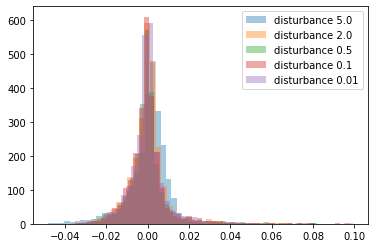

In [3]:
num_samples = 100
disturbances = [5.0, 2.0, 0.5, 0.1, 0.01]

# For each disturbance norm sample several latent space values.
latent_values = np.zeros((len(disturbances), num_samples, num_latent))
for j, dist in enumerate(disturbances):
    for i in range(num_samples):
        latent_values[j, i, :] = compute_latent(dist=dist) 
        
# Plot histogram per disturbance.
diff_undisturbed = latent_values - z_undisturbed
for j, dist in enumerate(disturbances):
    sns.distplot(diff_undisturbed[j, :, :].flatten(), label=f"disturbance {dist}", kde=False)
plt.legend()
plt.show()

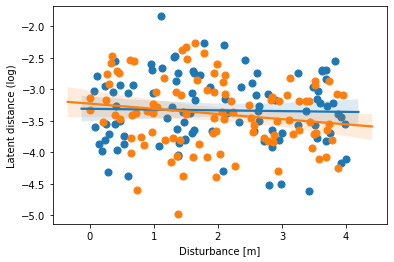

In [5]:
num_samples = 100

dis_dis_values = np.zeros((num_samples, 2))
for i in range(num_samples):
    disturbance = np.random.uniform(0, 4)
    dis_dis_values[i, 0] = disturbance
    dis_dis_values[i, 1] = np.linalg.norm(compute_latent(dist=disturbance) - z_undisturbed)
        
# Plot histogram per disturbance.
sns.regplot(dis_dis_values[:, 0], np.log(dis_dis_values[:, 1]), x_estimator=np.mean)
plt.xlabel("Disturbance [m]")
plt.ylabel("Latent distance (log)")
plt.show()